In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [303]:
# Define the data folder path
folder_path = './data/question_1b'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preferences{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [304]:
#System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [305]:
#PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile] # PV production per hour (kW) (No curtailment)

In [306]:
#Load parameters
load_data = appliance_params['load'][0]
L_max = load_data['max_load_kWh_per_hour'] # Maximum power consumption (kW)
L_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio'] # Minimum daily consumption (kWh)
L_ref = [L_max * ratio for ratio in L_ref_ratio] # PV production per hour (kW) (No curtailment)

In [307]:
print(L_ref)

[0.165, 0.12, 0.12, 0.12, 0.22499999999999998, 1.44, 2.2800000000000002, 2.4000000000000004, 1.8900000000000001, 0.66, 0.75, 1.0499999999999998, 0.8999999999999999, 0.8400000000000001, 1.35, 1.9500000000000002, 2.34, 2.7, 2.94, 2.64, 0.22499999999999998, 0.44999999999999996, 0.22499999999999998, 0.165]


In [308]:
#sum of L_ref
print(sum(L_ref))
print(sum(pv_prod_hourly))
print(sum(pv_profile))

27.945000000000004
13.469999999999999
4.49


In [309]:
#Temporal parameters
T = len(electricity_prices)  # 24 hours
Times = range(T) # Time horizon (24 hours)
# Discomfort parameter
alpha = 17

In [310]:
model = gp.Model("Energy_Optimization")

# Decision variables:
L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV (kW)
G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")  # Grid import (kW)
G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")  # Grid export (kW)
D_t = model.addVars(Times, lb=0, name="D_t")  # Discomfort (kW)

# Binary variables for mutual exclusivity of import/export - COMMENTED OUT (LP formulation)
# b_imp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_imp_t")  # 1 if importing, 0 otherwise
# b_exp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_exp_t")  # 1 if exporting, 0 otherwise


## Mathematical Formulation

### Objective Function

$$
\min \sum_{t \in T} \left[ G_{imp,t} \cdot (\tau_{imp} + p_t) - G_{exp,t} \cdot (p_t - \tau_{exp}) \right] + \alpha \sum_{t \in T} D_t
$$

Where:
- $G_{imp,t}$: Grid import at time $t$ (kW)
- $G_{exp,t}$: Grid export at time $t$ (kW)
- $\tau_{imp}$: Import tariff (DKK/kWh)
- $\tau_{exp}$: Export tariff (DKK/kWh)
- $p_t$: Electricity price at time $t$ (DKK/kWh)
- $D_t$: Discomfort at time $t$ (kW)
- $\alpha$: Discomfort penalty parameter (DKK/kW)

### Decision Variables

- $L_t \in [0, L_{max}]$: Load consumption at time $t$ (kW)
- $C_t \geq 0$: PV curtailment at time $t$ (kW)
- $G_{imp,t} \in [0, G_{imp,max}]$: Grid import at time $t$ (kW)
- $G_{exp,t} \in [0, G_{exp,max}]$: Grid export at time $t$ (kW)
- $D_t \geq 0$: Discomfort at time $t$ (kW)

### Constraints

**1. Power Balance:**
$$G_{imp,t} - G_{exp,t} = L_t - PV_t + C_t, \quad \forall t \in T$$

**2. PV Curtailment Limit:**
$$C_t \leq PV_t, \quad \forall t \in T$$

**3. Discomfort (Absolute Deviation):**
$$D_t \geq L_t - L_{ref,t}, \quad \forall t \in T$$
$$D_t \geq -(L_t - L_{ref,t}), \quad \forall t \in T$$

**4. Daily Energy Constraint (optional, used in flexibility analysis):**
$$\sum_{t \in T} L_t = \sum_{t \in T} L_{ref,t}$$

**5. Variable Bounds:**
- $0 \leq L_t \leq L_{max}$
- $0 \leq G_{imp,t} \leq G_{imp,max}$
- $0 \leq G_{exp,t} \leq G_{exp,max}$
- $C_t, D_t \geq 0$

### Notes
- This is an **LP formulation** (binary import/export constraints omitted for computational efficiency)
- The discomfort term $D_t$ captures deviations from the reference load profile $L_{ref,t}$
- The parameter $\alpha$ controls the trade-off between cost minimization and comfort maximization

In [311]:
#Objective function
# Minimize: Import Cost - Export Revenue + Discomfort Penalty
# Import Cost = G_imp * (tau_imp + price)
# Export Revenue = G_exp * (price - tau_exp)
# Discomfort Penalty = alpha * sum(D_t)
model.setObjective(
    gp.quicksum(G_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                G_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
    alpha * gp.quicksum(D_t[t] for t in Times),
    GRB.MINIMIZE)

In [312]:
#add constraints

# Curtailment constraint: Cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

# MILP constraints - COMMENTED OUT (LP formulation, no zero-tariff scenarios)
# Mutual exclusivity: Cannot import and export simultaneously
# Mutual_exclusivity_constraint = [
# 	model.addLConstr(b_imp_t[t] + b_exp_t[t] <= 1, name=f"Mutual_Exclusivity_{t}")
# 	for t in Times
# ]

# Link binary variables to import/export (big-M constraints)
# Import_binary_constraint = [
# 	model.addLConstr(G_imp_t[t] <= max_import * b_imp_t[t], name=f"Import_Binary_{t}")
# 	for t in Times
# ]

# Export_binary_constraint = [
# 	model.addLConstr(G_exp_t[t] <= max_export * b_exp_t[t], name=f"Export_Binary_{t}")
# 	for t in Times
# ]

# Discomfort constraints: D_t >= |L_t - L_ref[t]|
discomfort_constraint_1 = [
	model.addLConstr(D_t[t] >= L_t[t] - L_ref[t], name=f"discomfort_1_{t}")
	for t in Times
]

discomfort_constraint_2 = [
	model.addLConstr(D_t[t] >= -(L_t[t] - L_ref[t]), name=f"discomfort_2_{t}")
	for t in Times
]

# Power balance constraint
power_balance_constraint = [
	model.addLConstr(G_imp_t[t] - G_exp_t[t] == L_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]


In [313]:
#solve optimization problem
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 96 rows, 120 columns and 216 nonzeros
Model fingerprint: 0xdbe179e8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+00]
Presolve removed 33 rows and 42 columns
Presolve time: 0.00s
Presolved: 63 rows, 78 columns, 141 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 96 rows, 120 columns and 216 nonzeros
Model fingerprint: 0xdbe179e8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
 

In [314]:
#print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)")
    for t in Times:
        print(f"{t:4d} | {L_t[t].X:9.2f} | {C_t[t].X:15.2f} | {G_imp_t[t].X:15.2f} | {G_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f}")


Optimal solution found:
Total cost: 33.55 DKK
Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)
   0 |      0.17 |            0.00 |            0.17 |            0.00 |               0.00 |                      1.10
   1 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      1.05
   2 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      1.00
   3 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      0.90
   4 |      0.22 |            0.00 |            0.22 |            0.00 |               0.00 |                      0.85
   5 |      1.44 |            0.00 |            1.29 |            0.00 |               0.15 |                      1.01
   6 |      2.28 |            0.00 |            1.86 |            0.00 |               0.42 |               

In [315]:
print(sum(L_ref))

27.945000000000004


In [316]:
print(sum(pv_prod_hourly))

13.469999999999999


In [317]:
#print import
print(sum([G_imp_t[t].X for t in Times]))

17.835000000000004


In [318]:
#sum L_t
print(f"\nTotal Load Consumption: {sum(L_t[t].X for t in Times):.2f} kWh")


Total Load Consumption: 27.95 kWh


In [319]:
print('nyest')

nyest


# Part 1: Flexibility Parameter Sweep (α Sensitivity Analysis)

**Objective**: Analyze how the discomfort penalty α affects the cost-comfort trade-off

**Approach**: 
- Test α values from very low (highly flexible) to very high (highly inflexible)
- For each α, solve optimization and track cost vs. discomfort
- Constraint: Daily energy must equal sum(L_ref)

**Expected Result**: Trade-off curve showing that lower α (more flexibility) reduces cost but increases discomfort, while higher α (less flexibility) increases cost but reduces discomfort

In [320]:
# Function to run optimization with different alpha values
def run_alpha_sensitivity(alpha_values, pv_prod_hourly, L_ref, electricity_prices, 
                          tau_imp, tau_exp, max_import, max_export, L_max):
    """
    Run optimization for different alpha values and return results
    """
    results = []
    
    for alpha in alpha_values:
        # Create model
        model = gp.Model("Energy_Optimization_Alpha_Sweep")
        model.setParam('OutputFlag', 0)  # Suppress output
        
        Times = range(len(electricity_prices))
        
        # Decision variables
        L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")
        C_t = model.addVars(Times, lb=0, name="C_t")
        G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")
        G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")
        D_t = model.addVars(Times, lb=0, name="D_t")
        # b_imp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_imp_t")
        # b_exp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_exp_t")
        
        # Objective function with current alpha
        model.setObjective(
            gp.quicksum(G_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                        G_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
            alpha * gp.quicksum(D_t[t] for t in Times),
            GRB.MINIMIZE)
        
        # Constraints
        for t in Times:
            model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
            # model.addLConstr(b_imp_t[t] + b_exp_t[t] <= 1, name=f"Mutual_Exclusivity_{t}")
            # model.addLConstr(G_imp_t[t] <= max_import * b_imp_t[t], name=f"Import_Binary_{t}")
            # model.addLConstr(G_exp_t[t] <= max_export * b_exp_t[t], name=f"Export_Binary_{t}")
            model.addLConstr(D_t[t] >= L_t[t] - L_ref[t], name=f"discomfort_1_{t}")
            model.addLConstr(D_t[t] >= -(L_t[t] - L_ref[t]), name=f"discomfort_2_{t}")
            model.addLConstr(G_imp_t[t] - G_exp_t[t] == L_t[t] - pv_prod_hourly[t] + C_t[t], 
                           name=f"power_balance_{t}")
        
        # Daily energy constraint
        model.addLConstr(gp.quicksum(L_t[t] for t in Times) == sum(L_ref), 
                        name="daily_energy_constraint")
        
        # Solve
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            # Calculate metrics
            total_cost = sum(G_imp_t[t].X * (tau_imp + electricity_prices[t]) - 
                           G_exp_t[t].X * (electricity_prices[t] - tau_exp) for t in Times)
            total_discomfort = sum(D_t[t].X for t in Times)
            total_load = sum(L_t[t].X for t in Times)
            total_import = sum(G_imp_t[t].X for t in Times)
            total_export = sum(G_exp_t[t].X for t in Times)
            
            results.append({
                'alpha': alpha,
                'total_cost': total_cost,
                'total_discomfort': total_discomfort,
                'objective_value': model.objVal,
                'total_load': total_load,
                'total_import': total_import,
                'total_export': total_export,
                'load_profile': [L_t[t].X for t in Times]
            })
        else:
            print(f"Warning: No optimal solution for alpha={alpha}")
    
    return results


In [321]:
# Run alpha sensitivity analysis
alpha_values = [round(x * 0.2, 1) for x in range(0, 11)]  # 0.0, 0.2, 0.4, ..., 1.8, 2.0

print("Running alpha sensitivity analysis...")
alpha_results = run_alpha_sensitivity(
    alpha_values, pv_prod_hourly, L_ref, electricity_prices,
    tau_imp, tau_exp, max_import, max_export, L_max
)

print(f"\nCompleted! Tested {len(alpha_results)} alpha values.")
print("\nSummary:")
print(f"{'Alpha':<10} {'Cost (DKK)':<15} {'Discomfort':<15} {'Objective':<15}")
print("-" * 55)
for result in alpha_results:
    print(f"{result['alpha']:<10} {result['total_cost']:<15.2f} {result['total_discomfort']:<15.2f} {result['objective_value']:<15.2f}")

Running alpha sensitivity analysis...

Completed! Tested 11 alpha values.

Summary:
Alpha      Cost (DKK)      Discomfort      Objective      
-------------------------------------------------------
0.0        20.34           33.21           20.34          
0.2        21.33           20.28           25.39          
0.4        24.51           9.51            28.32          
0.6        24.94           8.61            30.11          
0.8        26.12           6.72            31.50          
1.0        28.55           4.23            32.78          
1.2        32.82           0.60            33.54          
1.4        33.55           0.00            33.55          
1.6        33.55           0.00            33.55          
1.8        33.55           0.00            33.55          
2.0        33.55           0.00            33.55          


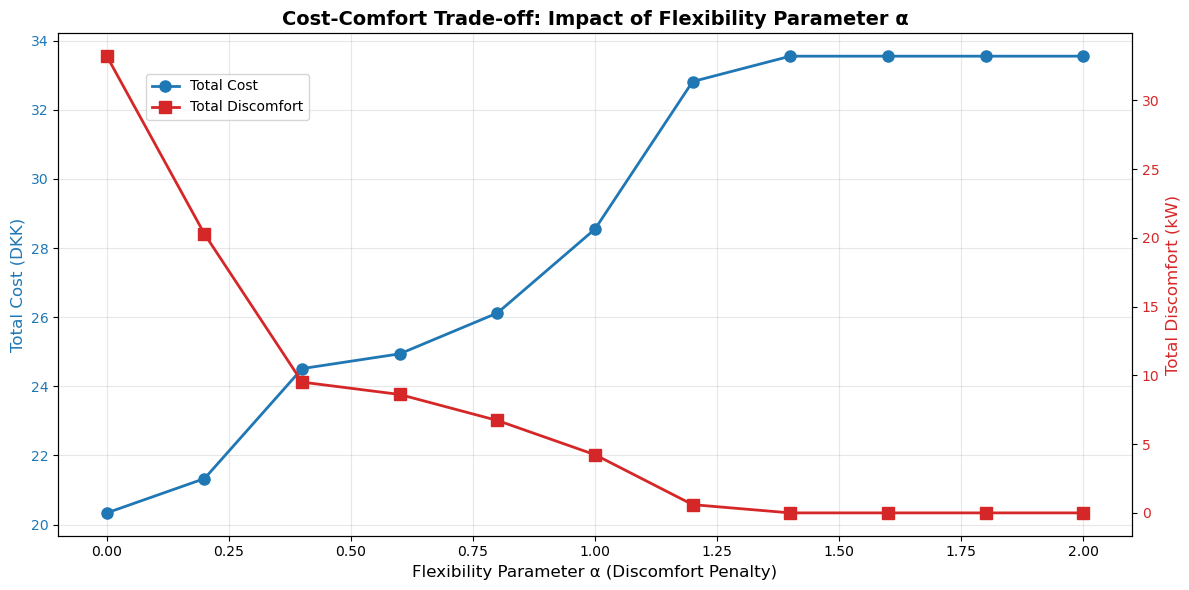


Key Insights:
- Most flexible (α=0.0): Cost = 20.34 DKK, Discomfort = 33.21 kW
- Mid-range (α=1.0): Cost = 28.55 DKK, Discomfort = 4.23 kW
- Least flexible (α=2.0): Cost = 33.55 DKK, Discomfort = 0.00 kW


In [322]:
# Plot alpha sensitivity results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract data
alphas = [r['alpha'] for r in alpha_results]
costs = [r['total_cost'] for r in alpha_results]
discomforts = [r['total_discomfort'] for r in alpha_results]

# Plot cost on left axis
color = 'tab:blue'
ax1.set_xlabel('Flexibility Parameter α (Discomfort Penalty)', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', color=color, fontsize=12)
ax1.plot(alphas, costs, marker='o', color=color, linewidth=2, markersize=8, label='Total Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot discomfort on right axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Discomfort (kW)', color=color, fontsize=12)
ax2.plot(alphas, discomforts, marker='s', color=color, linewidth=2, markersize=8, label='Total Discomfort')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title('Cost-Comfort Trade-off: Impact of Flexibility Parameter α', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=10)
fig.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Most flexible (α={alphas[0]}): Cost = {costs[0]:.2f} DKK, Discomfort = {discomforts[0]:.2f} kW")
print(f"- Mid-range (α={alphas[len(alphas)//2]}): Cost = {costs[len(costs)//2]:.2f} DKK, Discomfort = {discomforts[len(discomforts)//2]:.2f} kW")
print(f"- Least flexible (α={alphas[-1]}): Cost = {costs[-1]:.2f} DKK, Discomfort = {discomforts[-1]:.2f} kW")

# Part 2: Load Flexibility Scenarios (α = 0.5 fixed)

**Objective**: Compare how different levels of physical load flexibility impact optimization results

**Scenarios** (from most to least flexible):

1. **Scenario 1: 100% Flexible**
   - Constraint: Only `sum(L_t) = sum(L_ref)` (daily total)

2. **Scenario 2: 50% Flexible**
   - Constraint: `L_t[t] ≥ 0.5 × L_ref[t]` + daily total

3. **Scenario 3: 30% Flexible**
   - Constraint: `L_t[t] ≥ 0.7 × L_ref[t]` + daily total

4. **Scenario 4: 10% Flexible**
   - Constraint: `L_t[t] ≥ 0.9 × L_ref[t]` + daily total

5. **Scenario 5: 0% Flexible (Rigid)**
   - Constraint: `L_t[t] = L_ref[t]` (fixed)

**Fixed Parameters**: α = 0.5, daily energy = sum(L_ref)

In [323]:
# Function to run optimization with different flexibility constraints
def run_flexibility_scenario(scenario_name, flexibility_pct, alpha, pv_prod_hourly, L_ref, 
                             electricity_prices, tau_imp, tau_exp, max_import, max_export, L_max):
    """
    Run optimization with flexibility constraints
    flexibility_pct: 1.0 = fully flexible, 0.5 = 50% flexible, 0.0 = fully rigid
    """
    model = gp.Model(f"Energy_Optimization_{scenario_name}")
    model.setParam('OutputFlag', 0)
    
    Times = range(len(electricity_prices))
    
    # Decision variables
    L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")
    G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")
    D_t = model.addVars(Times, lb=0, name="D_t")
    # b_imp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_imp_t")
    # b_exp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_exp_t")
    
    # Objective function
    model.setObjective(
        gp.quicksum(G_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                    G_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
        alpha * gp.quicksum(D_t[t] for t in Times),
        GRB.MINIMIZE)
    
    # Standard constraints
    for t in Times:
        model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
        # model.addLConstr(b_imp_t[t] + b_exp_t[t] <= 1, name=f"Mutual_Exclusivity_{t}")
        # model.addLConstr(G_imp_t[t] <= max_import * b_imp_t[t], name=f"Import_Binary_{t}")
        # model.addLConstr(G_exp_t[t] <= max_export * b_exp_t[t], name=f"Export_Binary_{t}")
        model.addLConstr(D_t[t] >= L_t[t] - L_ref[t], name=f"discomfort_1_{t}")
        model.addLConstr(D_t[t] >= -(L_t[t] - L_ref[t]), name=f"discomfort_2_{t}")
        model.addLConstr(G_imp_t[t] - G_exp_t[t] == L_t[t] - pv_prod_hourly[t] + C_t[t], 
                       name=f"power_balance_{t}")
        
        # Flexibility constraint
        if flexibility_pct == 0.0:  # Fully rigid
            model.addLConstr(L_t[t] == L_ref[t], name=f"rigid_load_{t}")
        elif flexibility_pct < 1.0:  # Partial flexibility
            min_load = (1.0 - flexibility_pct) * L_ref[t]
            model.addLConstr(L_t[t] >= min_load, name=f"min_load_{t}")
    
    # Daily energy constraint
    model.addLConstr(gp.quicksum(L_t[t] for t in Times) == sum(L_ref), 
                    name="daily_energy_constraint")
    
    # Solve
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        # Calculate metrics
        total_cost = sum(G_imp_t[t].X * (tau_imp + electricity_prices[t]) - 
                       G_exp_t[t].X * (electricity_prices[t] - tau_exp) for t in Times)
        total_discomfort = sum(D_t[t].X for t in Times)
        total_load = sum(L_t[t].X for t in Times)
        total_import = sum(G_imp_t[t].X for t in Times)
        total_export = sum(G_exp_t[t].X for t in Times)
        
        return {
            'scenario': scenario_name,
            'flexibility_pct': flexibility_pct,
            'total_cost': total_cost,
            'total_discomfort': total_discomfort,
            'objective_value': model.objVal,
            'total_load': total_load,
            'total_import': total_import,
            'total_export': total_export,
            'load_profile': [L_t[t].X for t in Times],
            'curtailment': [C_t[t].X for t in Times],
            'grid_import': [G_imp_t[t].X for t in Times],
            'grid_export': [G_exp_t[t].X for t in Times]
        }
    else:
        print(f"Warning: No optimal solution for {scenario_name}")
        return None


In [324]:
# Run flexibility scenarios for multiple alpha values
scenarios = [
    ("Scenario 1: 100% Flexible", 1.0),
    ("Scenario 2: 50% Flexible", 0.5),
    ("Scenario 3: 30% Flexible", 0.3),
    ("Scenario 4: 10% Flexible", 0.1),
    ("Scenario 5: 0% Flexible (Rigid)", 0.0)
]

alpha_values_flex = [0.2, 0.5, 0.8, 1.0, 1.2]
all_results = {}

for alpha_val in alpha_values_flex:
    print(f"\n{'='*70}")
    print(f"Running flexibility scenarios with α = {alpha_val}...")
    print(f"{'='*70}")
    
    scenario_results_alpha = []
    
    for scenario_name, flexibility in scenarios:
        print(f"\nSolving {scenario_name} (α={alpha_val})...")
        result = run_flexibility_scenario(
            scenario_name, flexibility, alpha_val, pv_prod_hourly, L_ref,
            electricity_prices, tau_imp, tau_exp, max_import, max_export, L_max
        )
        if result:
            result['alpha'] = alpha_val  # Add alpha to result
            scenario_results_alpha.append(result)
            print(f"  ✓ Cost: {result['total_cost']:.2f} DKK, Discomfort: {result['total_discomfort']:.2f} kW")
    
    all_results[alpha_val] = scenario_results_alpha
    
    # Print summary for this alpha
    print(f"\n{'='*70}")
    print(f"FLEXIBILITY SCENARIOS SUMMARY (α = {alpha_val})")
    print(f"{'='*70}")
    print(f"{'Scenario':<35} {'Cost (DKK)':<15} {'Discomfort':<15} {'Objective':<15}")
    print("-" * 70)
    for result in scenario_results_alpha:
        print(f"{result['scenario']:<35} {result['total_cost']:<15.2f} {result['total_discomfort']:<15.2f} {result['objective_value']:<15.2f}")

# Store the α=0.5 results as the default for backward compatibility with existing plots
scenario_results = all_results[0.5]



Running flexibility scenarios with α = 0.2...

Solving Scenario 1: 100% Flexible (α=0.2)...
  ✓ Cost: 21.33 DKK, Discomfort: 20.28 kW

Solving Scenario 2: 50% Flexible (α=0.2)...
  ✓ Cost: 24.96 DKK, Discomfort: 11.91 kW

Solving Scenario 3: 30% Flexible (α=0.2)...
  ✓ Cost: 27.37 DKK, Discomfort: 7.28 kW

Solving Scenario 4: 10% Flexible (α=0.2)...
  ✓ Cost: 30.14 DKK, Discomfort: 4.97 kW

Solving Scenario 5: 0% Flexible (Rigid) (α=0.2)...
  ✓ Cost: 33.55 DKK, Discomfort: 0.00 kW

FLEXIBILITY SCENARIOS SUMMARY (α = 0.2)
Scenario                            Cost (DKK)      Discomfort      Objective      
----------------------------------------------------------------------
Scenario 1: 100% Flexible           21.33           20.28           25.39          
Scenario 2: 50% Flexible            24.96           11.91           27.34          
Scenario 3: 30% Flexible            27.37           7.28            28.83          
Scenario 4: 10% Flexible            30.14           4.97         

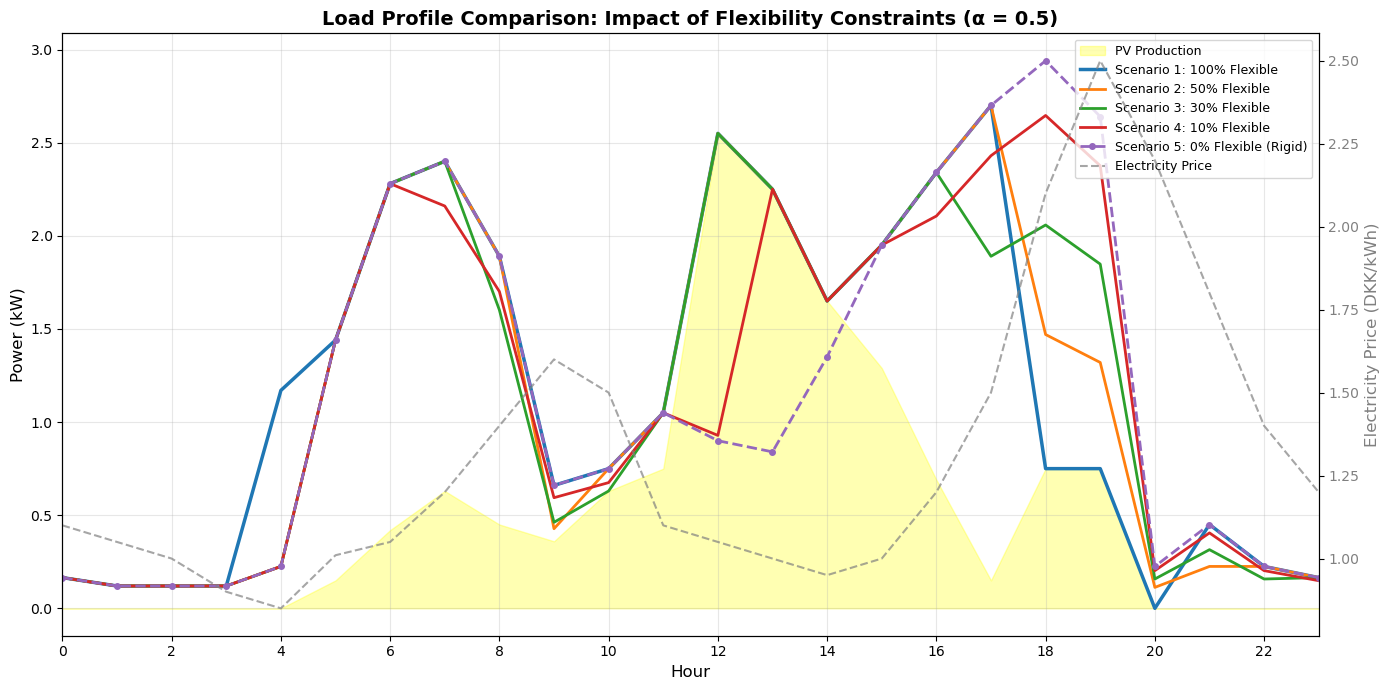


Key Observations:
- Scenario 1 (100% Flexible): Maximum load shifting to avoid high-price hours
- Scenario 5 (0% Flexible): Follows reference profile exactly, no optimization
- Partial flexibility scenarios show progressive constraint on load shifting


In [325]:
# Plot Load Profiles Comparison - All scenarios on one plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot PV production as yellow semi-transparent area
hours = range(24)
ax.fill_between(hours, 0, pv_prod_hourly, alpha=0.3, color='yellow', label='PV Production')

# Define colors for each scenario
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
line_styles = ['-', '-', '-', '-', '--']

# Plot load profiles for each scenario
for i, result in enumerate(scenario_results):
    ax.plot(hours, result['load_profile'], 
           color=colors[i], 
           linestyle=line_styles[i],
           linewidth=2.5 if i == 0 else 2,
           marker='o' if i == len(scenario_results)-1 else None,
           markersize=4,
           label=result['scenario'])

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Power (kW)', fontsize=12)
ax.set_title('Load Profile Comparison: Impact of Flexibility Constraints (α = 0.5)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 23)
ax.set_xticks(range(0, 24, 2))

# Add electricity prices on secondary y-axis
ax2 = ax.twinx()
ax2.plot(hours, electricity_prices, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Electricity Price')
ax2.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"- Scenario 1 (100% Flexible): Maximum load shifting to avoid high-price hours")
print(f"- Scenario 5 (0% Flexible): Follows reference profile exactly, no optimization")
print(f"- Partial flexibility scenarios show progressive constraint on load shifting")

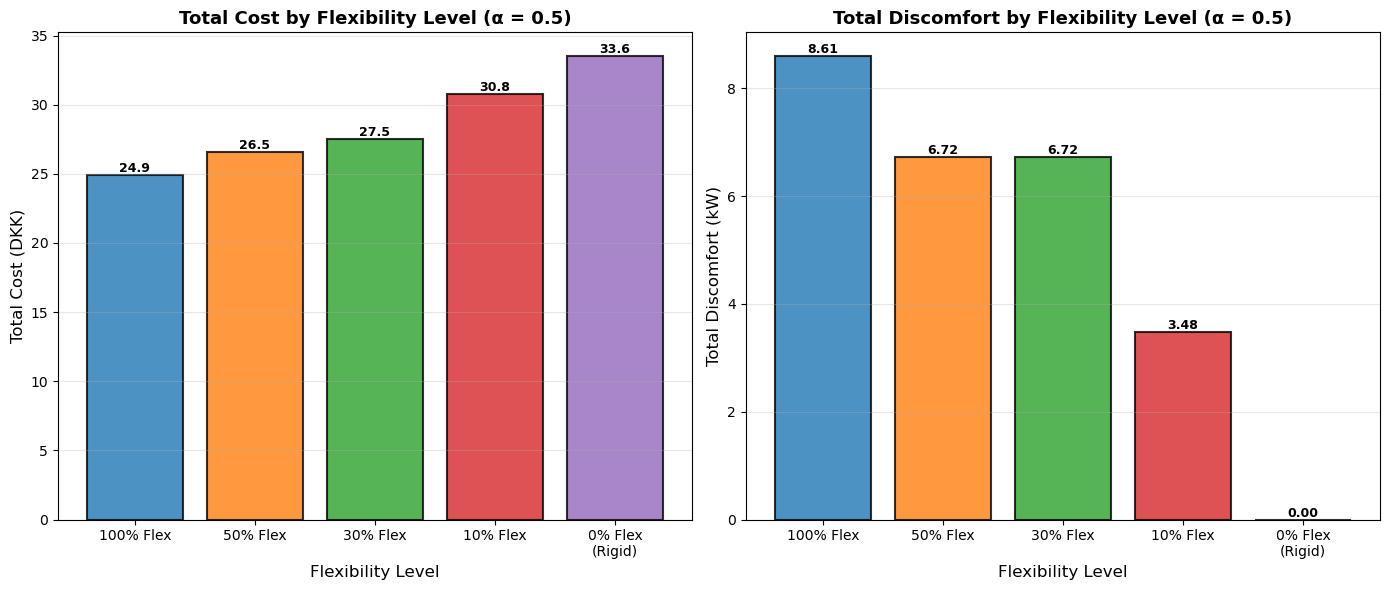


Cost Savings vs. Fully Rigid Scenario:
  Scenario 1: 100% Flexible          :   8.61 DKK (25.67% reduction)
  Scenario 2: 50% Flexible           :   7.01 DKK (20.89% reduction)
  Scenario 3: 30% Flexible           :   6.03 DKK (17.97% reduction)
  Scenario 4: 10% Flexible           :   2.76 DKK ( 8.21% reduction)


In [326]:
# Plot Cost & Discomfort Comparison Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract data and create clearer labels
scenario_labels = ['100% Flex', '50% Flex', '30% Flex', '10% Flex', '0% Flex\n(Rigid)']
costs = [r['total_cost'] for r in scenario_results]
discomforts = [r['total_discomfort'] for r in scenario_results]

x_pos = np.arange(len(scenario_labels))

# Plot costs
bars1 = ax1.bar(x_pos, costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Flexibility Level', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', fontsize=12)
ax1.set_title('Total Cost by Flexibility Level (α = 0.5)', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenario_labels, fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot discomforts
bars2 = ax2.bar(x_pos, discomforts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Flexibility Level', fontsize=12)
ax2.set_ylabel('Total Discomfort (kW)', fontsize=12)
ax2.set_title('Total Discomfort by Flexibility Level (α = 0.5)', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scenario_labels, fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate savings vs fully rigid
rigid_cost = scenario_results[-1]['total_cost']
print("\nCost Savings vs. Fully Rigid Scenario:")
for result in scenario_results[:-1]:
    savings = rigid_cost - result['total_cost']
    savings_pct = (savings / rigid_cost) * 100
    print(f"  {result['scenario']:<35}: {savings:>6.2f} DKK ({savings_pct:>5.2f}% reduction)")

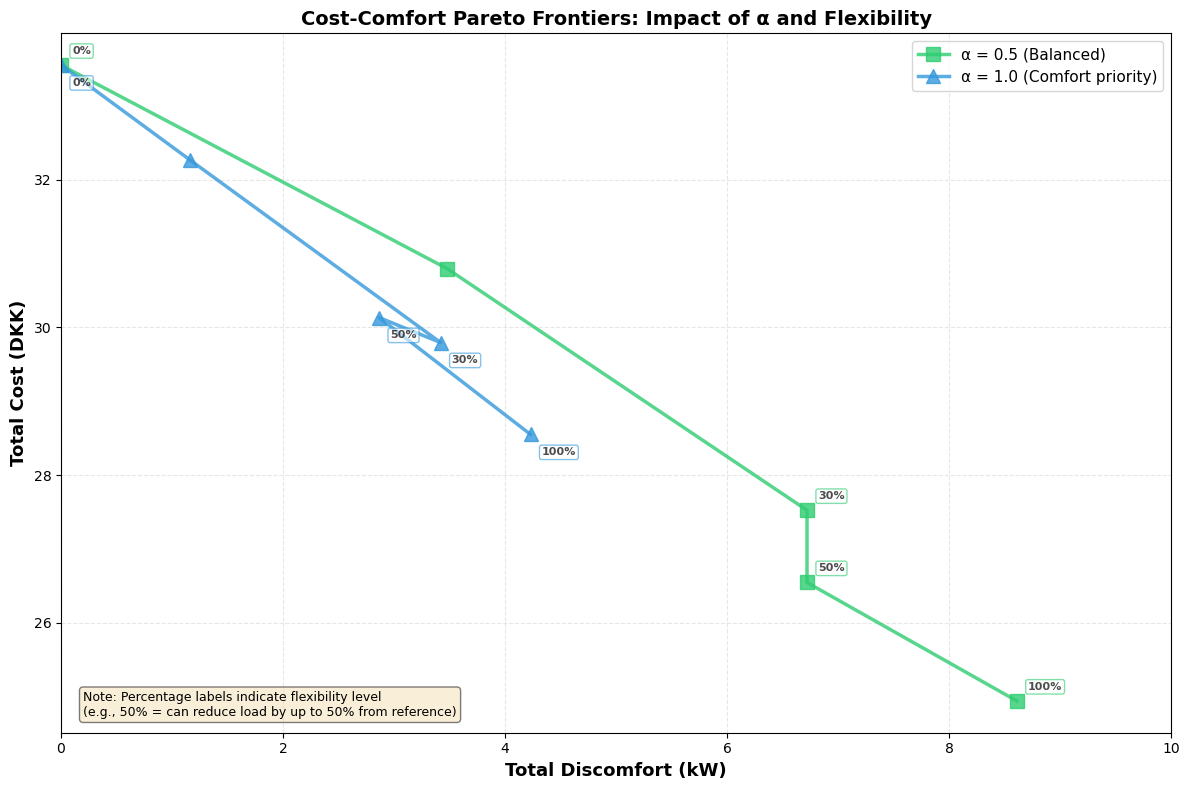


Pareto Frontier Analysis Across Alpha Values:

α = 0.5 (α = 0.5 (Balanced)):
  Cost range (0% to 100% flex): 8.61 DKK (25.7% reduction)
  Discomfort range: 8.61 kW
  Cost/Discomfort trade-off ratio: 1.00 DKK/kW

α = 1.0 (α = 1.0 (Comfort priority)):
  Cost range (0% to 100% flex): 5.00 DKK (14.9% reduction)
  Discomfort range: 4.23 kW
  Cost/Discomfort trade-off ratio: 1.18 DKK/kW


In [327]:
# Plot: Cost-Discomfort Trade-off (Pareto Frontier) with Multiple Alpha Values
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and markers for different alpha values (only plotting 0.0, 0.5, 1.0)
alpha_colors = {0.0: '#e74c3c', 0.5: '#2ecc71', 1.0: '#3498db'}
alpha_markers = {0.0: 'o', 0.5: 's', 1.0: '^'}
alpha_labels = {0.0: 'α = 0.0 (Cost priority)', 0.5: 'α = 0.5 (Balanced)', 1.0: 'α = 1.0 (Comfort priority)'}

# Only plot alpha values 0.0, 0.5, and 1.0
alphas_to_plot = [0.0, 0.5, 1.0]

for alpha_val in alphas_to_plot:
    if alpha_val in all_results:
        results = all_results[alpha_val]
        
        # Extract data
        discomforts = [r['total_discomfort'] for r in results]
        costs = [r['total_cost'] for r in results]
        flexibility_pcts = [r['flexibility_pct'] for r in results]
        
        # Plot line connecting points
        ax.plot(discomforts, costs, 
               color=alpha_colors[alpha_val],
               linewidth=2.5, 
               marker=alpha_markers[alpha_val],
               markersize=10, 
               alpha=0.8, 
               label=alpha_labels[alpha_val])
        
        # Annotate flexibility percentages for all alpha values
        for i, (d, c, f) in enumerate(zip(discomforts, costs, flexibility_pcts)):
            # Only label key points to avoid clutter
            if f in [1.0, 0.5, 0.3, 0.0]:  # Label 100%, 50%, 30%, and 0% (rigid)
                label = f"{int(f*100)}%" if f > 0 else "0%"
                # Adjust text position based on alpha to avoid overlaps
                offset_x = 8 if alpha_val == 0.5 else (-25 if alpha_val == 0.0 else 8)
                offset_y = 8 if alpha_val == 0.5 else (8 if alpha_val == 0.0 else -15)
                ax.annotate(label, 
                           xy=(d, c), 
                           xytext=(offset_x, offset_y), 
                           textcoords='offset points',
                           fontsize=8, 
                           fontweight='bold',
                           alpha=0.7,
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=alpha_colors[alpha_val], alpha=0.6))

ax.set_xlabel('Total Discomfort (kW)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Cost (DKK)', fontsize=13, fontweight='bold')
ax.set_title('Cost-Comfort Pareto Frontiers: Impact of α and Flexibility', 
            fontsize=14, fontweight='bold')
ax.set_xlim(0, 10)  # Limit x-axis (discomfort) to 10 kW
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='upper right')

# Add explanation text for percentage labels
ax.text(0.02, 0.02, 'Note: Percentage labels indicate flexibility level\n(e.g., 50% = can reduce load by up to 50% from reference)',
        transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nPareto Frontier Analysis Across Alpha Values:")
print("=" * 80)
for alpha_val in alphas_to_plot:
    if alpha_val in all_results:
        results = all_results[alpha_val]
        costs = [r['total_cost'] for r in results]
        discomforts = [r['total_discomfort'] for r in results]
        
        cost_range = costs[-1] - costs[0]
        discomfort_range = discomforts[0] - discomforts[-1]
        
        print(f"\nα = {alpha_val} ({alpha_labels[alpha_val]}):")
        print(f"  Cost range (0% to 100% flex): {cost_range:.2f} DKK ({(cost_range/costs[-1]*100):.1f}% reduction)")
        print(f"  Discomfort range: {discomfort_range:.2f} kW")
        print(f"  Cost/Discomfort trade-off ratio: {cost_range/discomfort_range if discomfort_range > 0 else 'N/A':.2f} DKK/kW" if discomfort_range > 0 else "  Discomfort range too small to calculate ratio")


## Analysis Summary

### Part 1: Alpha Sensitivity Analysis
The flexibility parameter α reveals a clear cost-comfort trade-off:
- **Low α (flexible)**: Consumers willing to deviate from preferred schedule achieve significant cost savings
- **High α (inflexible)**: Consumers prioritizing comfort pay premium for following preferred schedule
- **Diminishing returns**: Beyond certain α values, additional inflexibility provides minimal comfort benefit

### Part 2: Physical Flexibility Constraints
Different levels of physical load flexibility (with fixed α=17) demonstrate:
- **100% Flexible**: Maximum cost savings through optimal load shifting
- **50% Flexible**: Moderate savings while maintaining some schedule consistency
- **30% Flexible**: Limited optimization potential, closer to reference profile
- **10% Flexible**: Minimal savings, nearly rigid schedule
- **0% Flexible (Rigid)**: No optimization, highest cost as baseline

### Key Insight
The combination of economic preference (α) and physical constraints (flexibility %) determines actual consumer behavior. A consumer may be willing to shift load (low α) but constrained by appliance limitations (low flexibility %), or vice versa.

In [328]:
# Save plots function
import os

def save_scenario_plots():
    """Save all scenario plots to the Plots/Scenarios b/ folder"""
    
    # Create directory if it doesn't exist
    plot_dir = './Plots/Scenarios b/'
    os.makedirs(plot_dir, exist_ok=True)
    
    # Plot 1: Alpha Sensitivity
    fig, ax1 = plt.subplots(figsize=(12, 6))
    alphas = [r['alpha'] for r in alpha_results]
    costs = [r['total_cost'] for r in alpha_results]
    discomforts = [r['total_discomfort'] for r in alpha_results]
    
    # Plot cost on left axis
    color = 'tab:blue'
    ax1.set_xlabel('Flexibility Parameter α (Discomfort Penalty)', fontsize=12)
    ax1.set_ylabel('Total Cost (DKK)', color=color, fontsize=12)
    ax1.plot(alphas, costs, marker='o', color=color, linewidth=2, markersize=8, label='Total Cost')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)
    
    # Plot discomfort on right axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Discomfort (kW)', color=color, fontsize=12)
    ax2.plot(alphas, discomforts, marker='s', color=color, linewidth=2, markersize=8, label='Total Discomfort')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add title and legend
    plt.title('Cost-Comfort Trade-off: Impact of Flexibility Parameter α', fontsize=14, fontweight='bold')
    fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=10)
    fig.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'alpha_sensitivity.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Load Profiles Comparison
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot PV production as yellow semi-transparent area
    hours = range(24)
    ax.fill_between(hours, 0, pv_prod_hourly, alpha=0.3, color='yellow', label='PV Production')
    
    # Define colors for each scenario
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    line_styles = ['-', '-', '-', '-', '--']
    
    # Plot load profiles for each scenario
    for i, result in enumerate(scenario_results):
        ax.plot(hours, result['load_profile'], 
               color=colors[i], 
               linestyle=line_styles[i],
               linewidth=2.5 if i == 0 else 2,
               marker='o' if i == len(scenario_results)-1 else None,
               markersize=4,
               label=result['scenario'])
    
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('Power (kW)', fontsize=12)
    ax.set_title('Load Profile Comparison: Impact of Flexibility Constraints (α = 0.5)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 2))
    
    # Add electricity prices on secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(hours, electricity_prices, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Electricity Price')
    ax2.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'load_profiles_comparison.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 3: Cost & Discomfort Bar Charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Extract data and create clearer labels
    scenario_labels = ['100% Flex', '50% Flex', '30% Flex', '10% Flex', '0% Flex\n(Rigid)']
    costs = [r['total_cost'] for r in scenario_results]
    discomforts = [r['total_discomfort'] for r in scenario_results]
    
    x_pos = np.arange(len(scenario_labels))
    
    # Plot costs
    bars1 = ax1.bar(x_pos, costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Flexibility Level', fontsize=12)
    ax1.set_ylabel('Total Cost (DKK)', fontsize=12)
    ax1.set_title('Total Cost by Flexibility Level (α = 0.5)', fontsize=13, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(scenario_labels, fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot discomforts
    bars2 = ax2.bar(x_pos, discomforts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Flexibility Level', fontsize=12)
    ax2.set_ylabel('Total Discomfort (kW)', fontsize=12)
    ax2.set_title('Total Discomfort by Flexibility Level (α = 0.5)', fontsize=13, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(scenario_labels, fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'cost_discomfort_comparison.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 4: Pareto Frontier (Multi-Alpha)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors and markers for different alpha values (only plotting 0.0, 0.5, 1.0)
    alpha_colors = {0.0: '#e74c3c', 0.5: '#2ecc71', 1.0: '#3498db'}
    alpha_markers = {0.0: 'o', 0.5: 's', 1.0: '^'}
    alpha_labels = {0.0: 'α = 0.0 (Cost priority)', 0.5: 'α = 0.5 (Balanced)', 1.0: 'α = 1.0 (Comfort priority)'}
    
    # Only plot alpha values 0.0, 0.5, and 1.0
    alphas_to_plot = [0.0, 0.5, 1.0]
    
    for alpha_val in alphas_to_plot:
        if alpha_val in all_results:
            results = all_results[alpha_val]
            
            # Extract data
            discomforts = [r['total_discomfort'] for r in results]
            costs = [r['total_cost'] for r in results]
            flexibility_pcts = [r['flexibility_pct'] for r in results]
            
            # Plot line connecting points
            ax.plot(discomforts, costs, 
                   color=alpha_colors[alpha_val],
                   linewidth=2.5, 
                   marker=alpha_markers[alpha_val],
                   markersize=10, 
                   alpha=0.8, 
                   label=alpha_labels[alpha_val])
            
            # Annotate flexibility percentages for all alpha values
            for i, (d, c, f) in enumerate(zip(discomforts, costs, flexibility_pcts)):
                # Only label key points to avoid clutter
                if f in [1.0, 0.5, 0.3, 0.0]:  # Label 100%, 50%, 30%, and 0% (rigid)
                    label = f"{int(f*100)}%" if f > 0 else "0%"
                    # Adjust text position based on alpha to avoid overlaps
                    offset_x = 8 if alpha_val == 0.5 else (-25 if alpha_val == 0.0 else 8)
                    offset_y = 8 if alpha_val == 0.5 else (8 if alpha_val == 0.0 else -15)
                    ax.annotate(label, 
                               xy=(d, c), 
                               xytext=(offset_x, offset_y), 
                               textcoords='offset points',
                               fontsize=8, 
                               fontweight='bold',
                               alpha=0.7,
                               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=alpha_colors[alpha_val], alpha=0.6))
    
    ax.set_xlabel('Total Discomfort (kW)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Total Cost (DKK)', fontsize=13, fontweight='bold')
    ax.set_title('Cost-Comfort Pareto Frontiers: Impact of α and Flexibility', 
                fontsize=14, fontweight='bold')
    ax.set_xlim(0, 10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, loc='upper right')
    ax.text(0.02, 0.02, 'Note: Percentage labels indicate flexibility level\n(e.g., 50% = can reduce load by up to 50% from reference)',
            transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'pareto_frontier_multi_alpha.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ All plots saved to {plot_dir}")
    print(f"  - alpha_sensitivity.png")
    print(f"  - load_profiles_comparison.png")
    print(f"  - cost_discomfort_comparison.png")
    print(f"  - pareto_frontier_multi_alpha.png")

# Run the save function
save_scenario_plots()

✓ All plots saved to ./Plots/Scenarios b/
  - alpha_sensitivity.png
  - load_profiles_comparison.png
  - cost_discomfort_comparison.png
  - pareto_frontier_multi_alpha.png
